In [1]:
import os
os.chdir("/home/idpeshekhonov/AE")

In [2]:
import argparse
import inspect
import os
import numpy as np

import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from IPython.display import clear_output

from tqdm import tqdm
from typing import Union, Callable

from configs import Config
from src.data.collators import fc_collator, pretrain_collator, bw_collator
from src.data.dataset import get_train_dataset, get_val_dataset, SSLDataset, BlackWhiteDataset
from src.model import Simple
from src.model.BWAE import BWAE
from src.model.Simple import SimpleAE
from src.model.base_model import Autoencoder
from src.utils.utils import construct_grid, show_grid, CosineFocalLoss
from src.utils.utils import set_random_seed
from src.utils.mixup import mixup_data


import torchvision.transforms as T

from src.model.GANAE import GANAE, Descriminator

In [3]:
RANDOM_STATE = 322
set_random_seed(RANDOM_STATE)

In [4]:
def train_one_epoch(model, train_dataloader, optimizer, criterion, device="cuda", scheduler=None,
                    scheduler_frequency=None, mixup=True):
    len_dataloader = len(train_dataloader)
    losses = 0
    accs = 0
    model.train()
    with tqdm(total=len_dataloader) as prbar:
        for batch_idx, (features, targets) in enumerate(train_dataloader):
            features = features.to(device, non_blocking=True)
            if targets is not None:
                targets = targets.to(device, non_blocking=True)
            if mixup:
                features, targets_a, targets_b, mixup_lambda = mixup_data(features, targets, .8, device)

            preds = model(features)
            if mixup:
                loss = criterion(preds, (targets_a, targets_b), mixup_lambda, train=True)
            else:
                loss = criterion(preds, targets, train=False)
            loss.backward()
            optimizer.step()

            optimizer.zero_grad()
            losses += loss.detach()
            accs += torch.mean((preds.argmax(dim=1) == targets).float()).detach()

            if scheduler is not None and scheduler_frequency=="step":
                scheduler.step()

            prbar.set_description(f"epoch loss: {losses / (batch_idx + 1)}")
            prbar.update(1)

    losses /= (batch_idx + 1)
    accs /= (batch_idx + 1)
    return losses, accs


@torch.inference_mode()
def evaluate(model, dataloader, criterion, device="cuda", train=False):
    len_dataloader = len(dataloader)
    losses = 0
    accs = 0
    model.eval()
    with tqdm(total=len_dataloader) as prbar:
        for batch_idx, (features, targets) in enumerate(dataloader):
            features = features.to(device, non_blocking=True)
            if targets is not None:
                targets = targets.to(device, non_blocking=True)
            preds = model(features)
            loss = criterion(preds, targets)
            losses += loss.detach()
            accs += torch.mean((preds.argmax(dim=1) == targets).float()).detach()
            prbar.set_description(f"epoch loss: {losses / (batch_idx + 1)}, accuracy: {accs / (batch_idx + 1)}")
            prbar.update(1)

    losses /= (batch_idx + 1)
    accs /= (batch_idx + 1)
    return losses, accs


def train(model, optimizer, criterion, scheduler, train_loader, val_dataset,
          val_loader, checkpoint_path, device="cuda", num_epoches=10, num_warmup_epoches=1, scheduler_frequency=None, draw=False, mixup=True):
    train_losses = torch.empty(num_epoches, device=device)
    val_losses = torch.empty(num_epoches, device=device)
    train_accs = []
    val_accs = []
    best_loss_value = torch.inf
    os.makedirs(checkpoint_path, exist_ok=True)
    for epoch in range(1, num_epoches + 1):
        epoch_train_losses = train_one_epoch(model, train_loader, optimizer, criterion, device, scheduler, mixup=mixup)
        epoch_val_losses = evaluate(model, val_loader, criterion, device)

        train_losses[epoch - 1] = epoch_train_losses[0]
        train_accs.append(epoch_train_losses[1].item())
        val_losses[epoch - 1] = epoch_val_losses[0]
        val_accs.append(epoch_val_losses[1].item())
        
        
        clear_output()
        plt.plot(np.arange(1, epoch + 1), train_accs, c="C2", label="train")
        plt.plot(np.arange(1, epoch + 1), val_accs, c="C1", label="val")
        plt.legend()
        plt.grid()
        plt.show()

        if scheduler is not None and scheduler_frequency == "epoch":
            scheduler.step()
            
        if epoch == num_warmup_epoches - 1:
            for p in model.parameters():
                p.requires_grad_(True)

    return train_losses, val_losses


In [5]:
gae = GANAE(bw=False).encoder
dct = gae.state_dict()
old_dct = torch.load("checkpoints/simple/final.pth")["model"]
for k in old_dct.keys():
    if k.find("encoder") >= 0:
        dct[k[8:]] = old_dct[k] 
gae.load_state_dict(dct)
# torch.load("checkpoint/simple/final.pth")["model"]["encoder.model.conv1.weight"]

<All keys matched successfully>

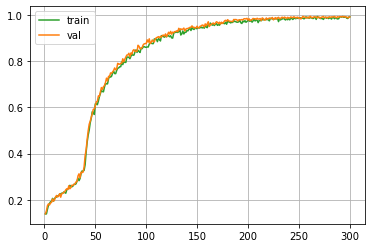

(tensor([1.0263, 0.9330, 0.8943, 0.8784, 0.8671, 0.8600, 0.8553, 0.8510, 0.8521,
         0.8466, 0.8427, 0.8422, 0.8379, 0.8376, 0.8333, 0.8333, 0.8243, 0.8260,
         0.8241, 0.8218, 0.8198, 0.8169, 0.8118, 0.8096, 0.8052, 0.8023, 0.8022,
         0.7993, 0.7971, 0.7930, 0.7893, 0.7867, 0.7814, 0.7789, 0.7749, 0.7692,
         0.7603, 0.7597, 0.7529, 0.7429, 0.6996, 0.6716, 0.6449, 0.6295, 0.6060,
         0.5826, 0.5632, 0.5560, 0.5470, 0.5251, 0.5149, 0.5030, 0.4987, 0.4846,
         0.4772, 0.4655, 0.4545, 0.4530, 0.4423, 0.4304, 0.4269, 0.4209, 0.4129,
         0.3990, 0.3948, 0.3907, 0.3789, 0.3761, 0.3782, 0.3751, 0.3662, 0.3549,
         0.3549, 0.3497, 0.3404, 0.3292, 0.3320, 0.3269, 0.3219, 0.3185, 0.3108,
         0.3055, 0.3009, 0.3055, 0.2951, 0.2886, 0.2896, 0.2884, 0.2784, 0.2737,
         0.2727, 0.2697, 0.2681, 0.2712, 0.2573, 0.2568, 0.2472, 0.2478, 0.2449,
         0.2422, 0.2420, 0.2381, 0.2305, 0.2334, 0.2290, 0.2273, 0.2285, 0.2096,
         0.2155, 0.2088, 0.2

In [7]:
device = "cuda"
batch_size = 128
num_epoches = 300
num_warmup_epoches = 40


gan = GANAE(bw=False)
gan.load_state_dict(torch.load("checkpoints/gae/final.pth")["G"])
for p in gan.parameters():
    p.requires_grad_(False)
gan = nn.Sequential(
    gan.encoder,
    nn.Linear(512, 10)
).to(device)

train_dataset = SSLDataset("data/data/train/labeled", train=True, labled=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)
# val_dataset = SSLDataset("data/data/test")
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)

opt = torch.optim.AdamW(gan.parameters(), lr=4e-3, betas=(0.9, 0.999), eps=1e-6, weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, total_steps=len(train_loader) * num_epoches, max_lr=4e-3,
                                                anneal_strategy="cos", pct_start=num_warmup_epoches/num_epoches, div_factor=100)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, len(train_dataset) // batch_size)

criterion = CosineFocalLoss(10, .1, 0.1, 2.)

train(gan, opt, criterion, scheduler, train_loader, train_dataset, train_loader, "checkpoints/simple",
          device, num_epoches=num_epoches, num_warmup_epoches=num_warmup_epoches, scheduler_frequency="step", draw=True, mixup=False)

In [12]:
gan = GANAE(bw=False)
gan = nn.Sequential(
    gan.encoder,
    nn.Linear(512, 10)
)
gan.load_state_dict(model.state_dict())

<All keys matched successfully>

In [ ]:
import glob
from skimage import io
import torchvision.transforms.functional as Tf

val_dataset = SSLDataset("data/data/test")
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)

ensemble_sz = 20
models = [gan, gae]

with open("submission.csv", "w") as f:
    f.write("id,class\n")
    imgs = list(glob.iglob("data/data/train/test/*.jpg", recursive=True))
    for img in tqdm(imgs, desc="Dataset loading"):
        image = io.imread(img)
        image = Tf.to_pil_image(image)
        logits = None
        for mdl in models:
            batch = torch.Tensor().to(device)
            for i in range(ensemble_sz):
                image_t = val_dataset.transforms(image).to(device)
                batch = torch.cat([batch, image_t.unsqueeze(0)], dim=0)
            if logits is None:
                logits = mdl(batch).mean(0)
            else:
                logits = 0.4 * logits + 0.6 * mdl(batch).mean(0)
        cls = (logits / len(models)).argmax()
        f.write(img[img.rfind("/")+1 :] + f",{train_dataset.data.classes[cls]}\n")

Dataset loading: 0it [00:00, ?it/s]
Dataset loading:  82%|████████▏ | 1691/2050 [18:01<13:51,  2.32s/it]  

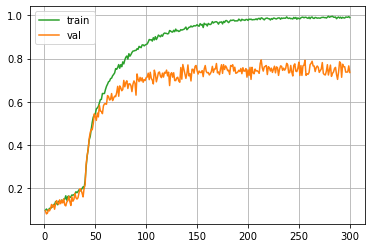

(tensor([1.3287, 1.2158, 1.0854, 0.9912, 0.9421, 0.9117, 0.8931, 0.8807, 0.8731,
         0.8667, 0.8609, 0.8614, 0.8590, 0.8555, 0.8550, 0.8528, 0.8488, 0.8504,
         0.8439, 0.8431, 0.8427, 0.8409, 0.8372, 0.8368, 0.8348, 0.8331, 0.8326,
         0.8321, 0.8307, 0.8278, 0.8241, 0.8224, 0.8234, 0.8183, 0.8187, 0.8150,
         0.8125, 0.8104, 0.8104, 0.7973, 0.7653, 0.7371, 0.7057, 0.6769, 0.6523,
         0.6280, 0.6051, 0.5842, 0.5704, 0.5540, 0.5407, 0.5302, 0.5186, 0.5062,
         0.4914, 0.4887, 0.4741, 0.4641, 0.4581, 0.4485, 0.4387, 0.4284, 0.4225,
         0.4179, 0.4086, 0.4048, 0.3939, 0.3871, 0.3831, 0.3722, 0.3723, 0.3651,
         0.3561, 0.3556, 0.3460, 0.3463, 0.3345, 0.3346, 0.3295, 0.3227, 0.3172,
         0.3175, 0.3047, 0.3035, 0.2978, 0.2912, 0.2843, 0.2856, 0.2818, 0.2783,
         0.2743, 0.2722, 0.2684, 0.2627, 0.2633, 0.2545, 0.2480, 0.2525, 0.2460,
         0.2425, 0.2410, 0.2365, 0.2305, 0.2274, 0.2207, 0.2208, 0.2133, 0.2196,
         0.2113, 0.2104, 0.2

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np

device = "cuda"
batch_size = 128
num_epoches = 300
num_warmup_epoches = 40

model = GANAE(bw=False)
# model = SimpleAE()
# model.load_state_dict(torch.load("checkpoints/gae/epoch_368.pth")["G"])
model.load_state_dict(torch.load("checkpoints/gae/final.pth")["G"])
for p in model.parameters():
    p.requires_grad_(False)
model = nn.Sequential(
    model.encoder,
    nn.Linear(512, 10)
).to(device)

train_dataset = SSLDataset("data/data/train/labeled", train=True, labled=True)
targs = train_dataset.data.targets

train_idx, valid_idx = train_test_split(np.arange(len(targs)), test_size=0.2,
                        shuffle=True, stratify=targs)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=6, pin_memory=True, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=6, pin_memory=True, sampler=valid_sampler)

opt = torch.optim.AdamW(model.parameters(), lr=4e-3, betas=(0.9, 0.999), eps=1e-6, weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, total_steps=len(train_loader) * num_epoches, max_lr=4e-3,
                                                anneal_strategy="cos", pct_start=num_warmup_epoches/num_epoches, div_factor=100)
criterion = CosineFocalLoss(10, .1, 0.1, 2.)

train(model, opt, criterion, scheduler, train_loader, train_dataset, val_loader, "checkpoints/simple",
          device, num_epoches=num_epoches, num_warmup_epoches=num_warmup_epoches, scheduler_frequency="step", draw=True, mixup=False)

In [16]:
torch.save({"model": model.state_dict()}, "checkpoint/classifier_72.pth")

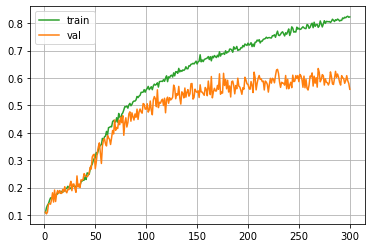

(tensor([1.1010, 0.9660, 0.9080, 0.8849, 0.8693, 0.8633, 0.8591, 0.8565, 0.8533,
         0.8514, 0.8509, 0.8492, 0.8483, 0.8460, 0.8440, 0.8421, 0.8419, 0.8398,
         0.8388, 0.8367, 0.8355, 0.8350, 0.8332, 0.8319, 0.8308, 0.8285, 0.8273,
         0.8261, 0.8244, 0.8229, 0.8231, 0.8188, 0.8193, 0.8164, 0.8176, 0.8141,
         0.8092, 0.8091, 0.8089, 0.8057, 0.8009, 0.7959, 0.7924, 0.7886, 0.7810,
         0.7758, 0.7718, 0.7629, 0.7569, 0.7554, 0.7474, 0.7448, 0.7419, 0.7334,
         0.7311, 0.7264, 0.7199, 0.7170, 0.7134, 0.7112, 0.7056, 0.7034, 0.6969,
         0.6959, 0.6893, 0.6883, 0.6857, 0.6802, 0.6824, 0.6766, 0.6744, 0.6738,
         0.6703, 0.6614, 0.6676, 0.6576, 0.6579, 0.6537, 0.6511, 0.6532, 0.6472,
         0.6416, 0.6453, 0.6416, 0.6410, 0.6375, 0.6325, 0.6341, 0.6327, 0.6293,
         0.6254, 0.6255, 0.6239, 0.6208, 0.6179, 0.6194, 0.6152, 0.6154, 0.6146,
         0.6098, 0.6080, 0.6079, 0.6060, 0.6037, 0.6045, 0.6043, 0.6009, 0.5995,
         0.5964, 0.5948, 0.5

In [11]:
from sklearn.model_selection import train_test_split
import numpy as np

device = "cuda"
batch_size = 128
num_epoches = 300
num_warmup_epoches = 40

model = GANAE(bw=True).to(device)
model.load_state_dict(torch.load("checkpoints/gae/final.pth")["G"])
for p in model.parameters():
    p.requires_grad_(False)
model = nn.Sequential(
    model.encoder,
    nn.Linear(512, 10)
).to(device)

train_dataset = BlackWhiteDataset("data/data/train/labeled", labled=True)
targs = train_dataset.data.targets

train_idx, valid_idx = train_test_split(np.arange(len(targs)), test_size=0.2,
                        shuffle=True, stratify=targs)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=6, pin_memory=True, collate_fn=bw_collator, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=6, pin_memory=True, collate_fn=bw_collator, sampler=valid_sampler)

opt = torch.optim.AdamW(model.parameters(), lr=4e-3, betas=(0.9, 0.999), eps=1e-6, weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, total_steps=len(train_loader) * num_epoches, max_lr=4e-3,
                                                anneal_strategy="cos", pct_start=num_warmup_epoches/num_epoches, div_factor=100)
criterion = CosineFocalLoss(10, .1, 0.1, 2.)

train(model, opt, criterion, scheduler, train_loader, train_dataset, val_loader, "checkpoints/simple",
          device, num_epoches=num_epoches, num_warmup_epoches=num_warmup_epoches, scheduler_frequency="step", draw=True, mixup=False)

In [ ]:
import glob
from skimage import io
import torchvision.transforms.functional as Tf

val_dataset = BlackWhiteDataset("data/data/test")
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)

ensemble_sz = 1

with open("submission.csv", "w") as f:
    f.write("id,class\n")
    imgs = list(glob.iglob("data/data/train/test/*.jpg", recursive=True))
    for img in tqdm(imgs, desc="Dataset loading"):
        image = io.imread(img)
        image = Tf.to_pil_image(image)
        logits = None
        for i in range(ensemble_sz):
            image_t = val_dataset.transforms(image).to(device)
            if logits is None:
                logits = model(image_t.unsqueeze(0))
            else:
                logits += model(image_t.unsqueeze(0))
        logits /= ensemble_sz
        cls = logits.argmax()
        f.write(img[img.rfind("/")+1 :] + f",{train_dataset.data.classes[cls]}\n")